In [1]:
import pandas as pd
import numpy as np
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import transformers
from transformers import pipeline
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from itertools import chain
from nltk import NaiveBayesClassifier

# Sentiment analysis

This is a basic sentiment analysis with a Dataset related to amazon reviews

## We import the data

In [2]:
data = pd.read_csv('reviews.csv')

We confirm the data was correctly readed

In [3]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


Now, we can maybe see what is the structure of a review

In [6]:
data['Text'][1]

'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".'

So, now we can lower case everything and take the punctuation out

In [7]:
data['Text_clean'] = data.apply(lambda x: re.sub(r"[^\w\s]", "", x['Text'].lower()), axis=1)

Now, we check how it looks now

In [8]:
data['Text_clean'][1]

'product arrived labeled as jumbo salted peanutsthe peanuts were actually small sized unsalted not sure if this was an error or if the vendor intended to represent the product as jumbo'

Now we have a column full with ready-to-analyze reviews

## Vader analysis

In [10]:
vader_sentiment = SentimentIntensityAnalyzer()

In [13]:
data['vader_sentiment_score'] = data['Text_clean'].apply(lambda review: vader_sentiment.polarity_scores(review)['compound'])

In [14]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Text_clean,vader_sentiment_score
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,i have bought several of the vitality canned d...,0.9441
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled as jumbo salted peanut...,-0.5664
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,this is a confection that has been around a fe...,0.8138
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,if you are looking for the secret ingredient i...,0.4404
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffy at a great price there was a wide...,0.9468


Now we have the scores for all the data we have.

We can now use a simple plot to show what we found

In [15]:
bins = [-1, -0.1, 0.1, 1]
names = ['negative', 'neutral', 'positive']

data['vader_sentiment_label'] = pd.cut(data['vader_sentiment_score'], bins, labels=names)

<Axes: xlabel='vader_sentiment_label'>

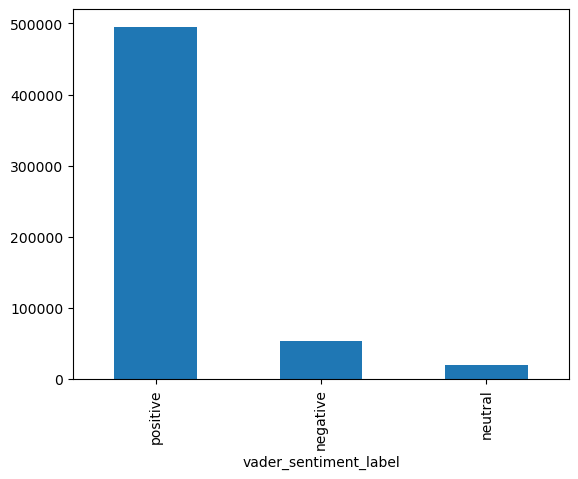

In [16]:
data['vader_sentiment_label'].value_counts().plot.bar()

## Transformers Pipeline

Now, we can use a model to analyze the same data

In [20]:
transformer_pipeline = pipeline('sentiment-analysis', truncation=True)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


This could take hours, feel free to try with the complete dataset. In this case, i'm just going to use a few rows

In [22]:
data[:10]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Text_clean,vader_sentiment_score,vader_sentiment_label
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,i have bought several of the vitality canned d...,0.9441,positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled as jumbo salted peanut...,-0.5664,negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,this is a confection that has been around a fe...,0.8138,positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,if you are looking for the secret ingredient i...,0.4404,positive
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffy at a great price there was a wide...,0.9468,positive
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,i got a wild hair for taffy and ordered this f...,0.8253,positive
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...,this saltwater taffy had great flavors and was...,0.9273,positive
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...,this taffy is so good it is very soft and che...,0.9436,positive
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...,right now im mostly just sprouting this so my ...,0.6369,positive
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...,this is a very healthy dog food good for their...,0.8313,positive


In [25]:
transformer_labels=[]
for review in data['Text_clean'][:200].values:
    sentiment_list = transformer_pipeline(review)
    sentiment_label = [sent['label'] for sent in sentiment_list]
    transformer_labels.append(sentiment_label)

In [36]:
plot_data_transformer = pd.DataFrame(columns=['text'])

In [37]:
plot_data_transformer['text'] = transformer_labels

<Axes: xlabel='text'>

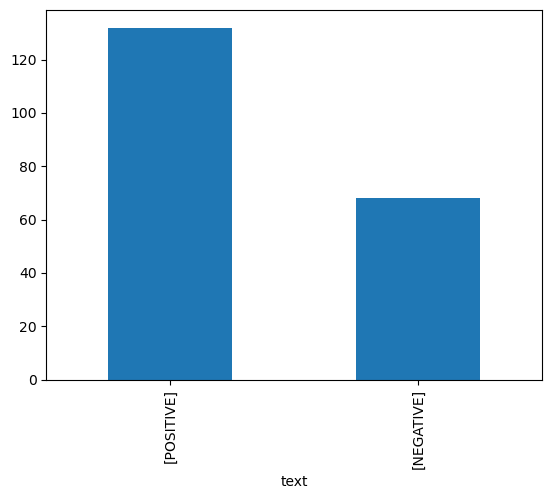

In [39]:
plot_data_transformer['text'].value_counts().plot.bar()